## Loan Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,classification_report
from mpl_toolkits.mplot3d import Axes3D # 3d scatter plot
import time
%matplotlib inline

In [3]:
# parameters
n_centroids = 2
n_init = 40
n_seed = 111

In [4]:
# load training set
train = pd.read_csv('./clean_data/loan_train.txt',index_col=False)
train_labels = train['loan_status'].values
train = train.drop('loan_status',axis=1).values

# load testing set
test = pd.read_csv('./clean_data/loan_test.txt',index_col=False)
test_labels = test['loan_status'].values
test = test.drop('loan_status',axis=1).values

In [5]:
# normalize everything such that categoricals are not affected
a = train
#train = (a - a.min()) / (a.max() - a.min())
train = (a - a.mean()) / np.std(a)

b = test
#test = (b - b.min()) / (b.max() - b.min())
test = (b - b.mean()) / np.std(b)

In [12]:
np.histogram(a[2])

(array([25,  2,  0,  0,  0,  0,  0,  0,  0,  1]),
 array([     0.,   9200.,  18400.,  27600.,  36800.,  46000.,  55200.,
         64400.,  73600.,  82800.,  92000.]))

### Apply K Means

In [5]:
kmeans = KMeans(n_clusters=n_centroids, n_init=n_init, n_jobs=4)
kmeans.fit(train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=40, n_jobs=4, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [6]:
print(confusion_matrix(train_labels,kmeans.labels_))
print(classification_report(train_labels,kmeans.labels_))

[[17533     1]
 [46673     2]]
             precision    recall  f1-score   support

          0       0.27      1.00      0.43     17534
          1       0.67      0.00      0.00     46675

avg / total       0.56      0.27      0.12     64209



### Predicting on test set

In [7]:
b = kmeans.predict(test)

In [8]:
print(confusion_matrix(test_labels, b))
print(classification_report(test_labels, b))

[[ 7845     0]
 [20691     1]]
             precision    recall  f1-score   support

          0       0.27      1.00      0.43      7845
          1       1.00      0.00      0.00     20692

avg / total       0.80      0.27      0.12     28537



## Choosing number of clusters via Silhoutte + Model Complexity

In [9]:
from sklearn.metrics import silhouette_samples, silhouette_score
n_seed = 111
nclusters = 50
nfeatures = 65
data_frac = 5000

In [10]:
X = train #.values # converting df to np.array
X = X[0:data_frac]
y = train_labels

In [11]:
sil = []
time_clust = []
for iclusters in range(2,nclusters):
    start = time.time()
    clusterer = KMeans(n_clusters=iclusters,random_state=n_seed)
    cluster_labels = clusterer.fit_predict(X)
    end = time.time()
    sil.append(silhouette_score(X, cluster_labels))
    time_clust.append(end - start) 
    

In [12]:
time_iter = []
time_sample = []
niter = nclusters # just for plotting them togather
for iiter in range(2,niter):
    # iterations
    start = time.time()
    clusterer = KMeans(n_clusters= 4, random_state=n_seed, n_init = iiter, max_iter = 100)
    cluster_labels = clusterer.fit_predict(X)
    end = time.time()
    time_iter.append(end - start)    
    #samples
    start = time.time()
    isample = int(data_frac * iiter/100)
    cluster_labels = clusterer.fit_predict(X[0:isample])
    end = time.time()
    time_sample.append(end - start)      
       

In [13]:
y = np.asarray(sil)
x = range(2,nclusters)
sil_max = x[y.argmax()]

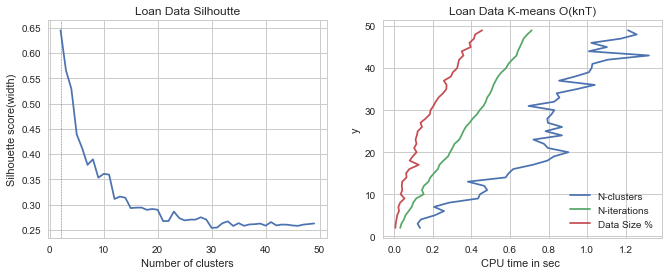

In [14]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(11,4))
p1 = plt.subplot(121, title = 'Loan Data Silhoutte')
plt.plot(x, y)
plt.ylabel('Silhouette score(width)')
plt.xlabel('Number of clusters')
plt.axvline(x=sil_max,color='magenta', linestyle='--', linewidth=0.5)

p2 = plt.subplot(122, title = 'Loan Data K-means O(knT)')
plt.plot(time_clust,x)
plt.plot(time_iter,x)
plt.plot(time_sample,x)
plt.legend(["N-clusters","N-iterations","Data Size %"],loc=4)
plt.xlabel('CPU time in sec ')
plt.ylabel('y')

**The average complexity is given by O(k n T), were n is the number of samples and T is the number of iteration.**

### Apply EM

In [15]:
from sklearn.mixture import GaussianMixture
n_init = 2
n_seed = 111

In [16]:
gm = GaussianMixture(n_components=n_centroids, random_state=n_seed, n_init=n_init, max_iter=100)
gm.fit(train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=2, precisions_init=None,
        random_state=111, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [17]:
gm_labels = gm.predict(train)

In [18]:
print(confusion_matrix(train_labels, gm_labels))
print(classification_report(train_labels, gm_labels))

[[ 2408 15126]
 [ 5836 40839]]
             precision    recall  f1-score   support

          0       0.29      0.14      0.19     17534
          1       0.73      0.87      0.80     46675

avg / total       0.61      0.67      0.63     64209



In [19]:
test_gm = gm.predict(test)
print(confusion_matrix(test_labels, test_gm))
print(classification_report(test_labels, test_gm))

[[ 7845     0]
 [20692     0]]
             precision    recall  f1-score   support

          0       0.27      1.00      0.43      7845
          1       0.00      0.00      0.00     20692

avg / total       0.08      0.27      0.12     28537



/home/talant/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## EM model Complexity + Choosing n-components

In [20]:
BIC = []
AIC = []
time_components = []
ncomponents = 40
for icomponents in range(1,ncomponents):
    start = time.time()
    clusterer = GaussianMixture(icomponents, n_init = 10, covariance_type='full').fit(X) 
    end = time.time()
    BIC.append(clusterer.bic(X))
    AIC.append(clusterer.aic(X))
    time_components.append(end - start) 

In [21]:
time_iter = []
time_sample = []
niter = ncomponents  
for iiter in range(1,niter):
    # iterations
    start = time.time()
    clusterer = GaussianMixture(n_components = 2, n_init=iiter, covariance_type='full',random_state=0).fit(X) 
    end = time.time()
    time_iter.append(end - start)    
    #samples
    start = time.time()
    isample = int(data_frac * iiter/100)
    clusterer = GaussianMixture(n_components = 2, n_init = 4, covariance_type='full', random_state=0).fit(X[0:isample]) 
    end = time.time()
    time_sample.append(end - start)      

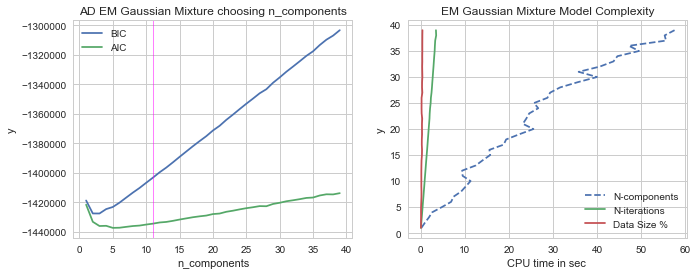

In [22]:
x = np.arange(1, ncomponents)
sns.set_style("whitegrid")
fig = plt.figure(figsize=(11,4))

p1 = plt.subplot(121, title = 'AD EM Gaussian Mixture choosing n_components')
plt.plot(x, BIC, label='BIC')
plt.plot(x, AIC, label='AIC')
plt.axvline(x=11,color='magenta', linewidth=0.5)
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('y')

p2 = plt.subplot(122, title = 'EM Gaussian Mixture Model Complexity')
plt.plot(time_components,x, linestyle='--')
plt.plot(time_iter,x)
plt.plot(time_sample,x)
plt.legend(["N-components","N-iterations","Data Size %"],loc=4)
plt.xlabel('CPU time in sec ')
plt.ylabel('y')

# Note!
**Since training was not provided any information about target feature, it makes sence to see very close accuracy
on both training and testing sets.**

### Apply PCA to Normalized Data 

In [23]:
from sklearn.decomposition import PCA, FastICA

In [24]:
train = pd.DataFrame(train)
n_features = len(train.columns)

## Try it on whole data

In [25]:
# when n_comp is given as fraction and svd solver is full, then algorithm chooses # pc components
# such that model explains "n_components= of varience
pca_all = PCA(n_components=0.99,  svd_solver = 'full')
pca_all.fit(train)
pca_n = pca_all.transform(train)

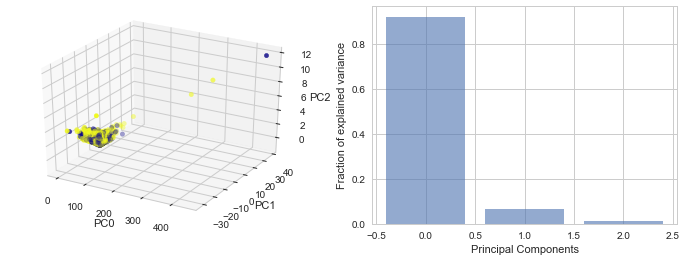

In [26]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(pca_n[:,0], pca_n[:,1],pca_n[:,2],c=train_labels,cmap='plasma')
ax1.set_xlabel('PC0')
ax1.set_ylabel('PC1')
ax1.set_zlabel('PC2')

ax2 = fig.add_subplot(122)
#ax2.scatter(pca_n[:,0], pca_n[:,1],c=train_labels,cmap='plasma')
#plt.xlabel('PC0', fontsize = 10)
#plt.ylabel('PC1', fontsize = 10)
aig_vals = pca_all.explained_variance_ratio_[0:10]
y_pos = np.arange(len(aig_vals))
plt.bar(y_pos, aig_vals, align='center', alpha=0.6)
plt.ylabel('Fraction of explained variance')
plt.xlabel('Principal Components') 


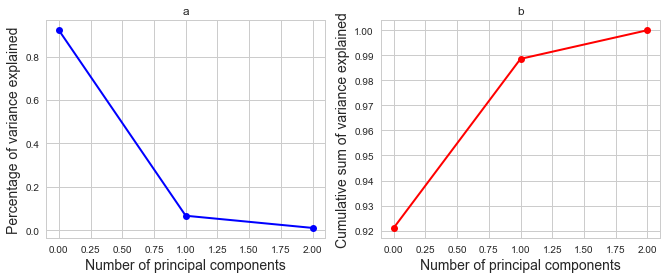

In [27]:
y = pca_all.explained_variance_ratio_
x = np.arange(len(y))

# plot pca
fig = plt.figure(figsize=(11,4))
sub1 = plt.subplot(121, title = 'a')
plt.xlabel('Number of principal components', fontsize = 14)
plt.ylabel('Percentage of variance explained', fontsize = 14)
plt.plot(x ,y, '-o',lw=2., color='blue')

sub2 = plt.subplot(122, title = 'b')
plt.xlabel('Number of principal components', fontsize = 14)
plt.ylabel('Cumulative sum of variance explained', fontsize = 14)
plt.plot(x ,np.cumsum(y), '-o',lw=2.0, color='red')

### Apply k-means to PCA output

In [28]:
kmeans = KMeans(n_clusters=n_centroids, random_state = n_seed)
kmeans.fit(pca_n)
print(confusion_matrix(train_labels,kmeans.labels_))
print(classification_report(train_labels,kmeans.labels_))

[[17533     1]
 [46673     2]]
             precision    recall  f1-score   support

          0       0.27      1.00      0.43     17534
          1       0.67      0.00      0.00     46675

avg / total       0.56      0.27      0.12     64209



### Apply EM to PCA output

In [29]:
gm = GaussianMixture(n_components=n_centroids, random_state=n_seed, n_init=n_init, max_iter=100)
gm.fit(pca_n)
gm_labels = gm.predict(pca_n)
print(confusion_matrix(train_labels, gm_labels))
print(classification_report(train_labels, gm_labels))

[[ 1507 16027]
 [ 4097 42578]]
             precision    recall  f1-score   support

          0       0.27      0.09      0.13     17534
          1       0.73      0.91      0.81     46675

avg / total       0.60      0.69      0.62     64209



##  ICA

In [30]:
ica =FastICA(algorithm='deflation', tol=0.001, whiten=True, fun='logcosh', max_iter=50, random_state=n_seed)
ica_all = ica.fit_transform(train)

### Applying k-means to ICA output

In [31]:
kmeans = KMeans(n_clusters=n_centroids, random_state = n_seed)
kmeans.fit(ica_all)
print(confusion_matrix(train_labels,kmeans.labels_))
print(classification_report(train_labels,kmeans.labels_))

[[ 5453 12081]
 [15961 30714]]
             precision    recall  f1-score   support

          0       0.25      0.31      0.28     17534
          1       0.72      0.66      0.69     46675

avg / total       0.59      0.56      0.58     64209



### Applying EM to ICA output

In [32]:
gm = GaussianMixture(n_components=n_centroids, random_state=n_seed, n_init=n_init, max_iter=100)
gm.fit(ica_all)
gm_labels = gm.predict(ica_all)
print(confusion_matrix(train_labels, gm_labels))
print(classification_report(train_labels, gm_labels))

[[ 6635 10899]
 [ 9725 36950]]
             precision    recall  f1-score   support

          0       0.41      0.38      0.39     17534
          1       0.77      0.79      0.78     46675

avg / total       0.67      0.68      0.68     64209



In [33]:
from scipy.stats import kurtosis
y = kurtosis(ica_all, fisher=True)
x = np.arange(len(y)) 

In [34]:
kurt_max = x[y.argmax()]
kurtosis_thresh = y.max()/3

### Visualize ICA components with highest Kurtosis

In [35]:
tmp = [y > kurtosis_thresh]
indx = np.where(tmp)[1]

In [36]:
ica_all = pd.DataFrame(ica_all)
ica_keep = ica_all[indx]

In [37]:
indx

array([0, 1, 2, 3, 4, 5, 6, 7])

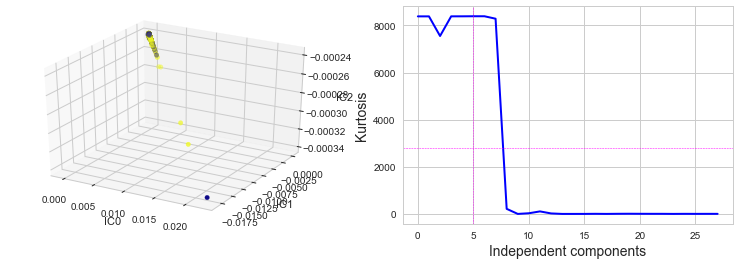

In [38]:
fig = plt.figure(figsize=(13,4))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(ica_keep[indx[0]], ica_keep[indx[1]],ica_keep[indx[2]],c=train_labels,cmap='plasma')
ax1.set_xlabel('IC0')
ax1.set_ylabel('IC1')
ax1.set_zlabel('IC2')

ax2 = fig.add_subplot(122)
#ax2.scatter(ica_keep[indx[0]], ica_keep[indx[1]],c=train_labels,cmap='plasma')
#plt.xlabel('IC0', fontsize = 10)
#plt.ylabel('IC1', fontsize = 10)
# plot ica
plt.xlabel('Independent components', fontsize = 14)
plt.ylabel('Kurtosis', fontsize = 14)
plt.plot(x ,y, '-',lw=2., color='blue')
plt.axvline(x=kurt_max,color='magenta', linestyle='--', linewidth=0.5)
plt.axhline(y=kurtosis_thresh,color='magenta', linestyle='--', linewidth=0.5)

### Apply k-means to reduced dim by ICA

In [39]:
kmeans = KMeans(n_clusters=n_centroids, random_state = n_seed)
kmeans.fit(ica_keep)
print(confusion_matrix(train_labels,kmeans.labels_))
print(classification_report(train_labels,kmeans.labels_))

[[    1 17533]
 [    2 46673]]
             precision    recall  f1-score   support

          0       0.33      0.00      0.00     17534
          1       0.73      1.00      0.84     46675

avg / total       0.62      0.73      0.61     64209



### Apply EM to reduced dim by ICA

In [40]:
gm = GaussianMixture(n_components=n_centroids, random_state=n_seed, n_init=n_init, max_iter=100)
gm.fit(ica_keep)
gm_labels = gm.predict(ica_keep)
print(confusion_matrix(train_labels, gm_labels))
print(classification_report(train_labels, gm_labels))

[[  262 17272]
 [  756 45919]]
             precision    recall  f1-score   support

          0       0.26      0.01      0.03     17534
          1       0.73      0.98      0.84     46675

avg / total       0.60      0.72      0.62     64209



## Random Projections

In [41]:
from sklearn import random_projection
transformer = random_projection.GaussianRandomProjection(eps=0.5,random_state=n_seed,n_components=30)
RP = transformer.fit_transform(train)

/home/talant/anaconda3/lib/python3.5/site-packages/sklearn/random_projection.py:378: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (28 < 30).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)


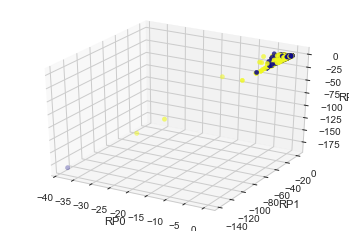

In [42]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(6,4))
ax1=fig.add_subplot(111, projection='3d')
ax1.scatter(RP[:,0], RP[:,1],RP[:,2],c=train_labels,cmap='plasma')
ax1.set_xlabel('RP0')
ax1.set_ylabel('RP1')
ax1.set_zlabel('RP2')